In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [ ]:
# Xavier Initialization Function
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

In [ ]:
# Data Preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.85MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.65MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [ ]:
# Model, Optimizer, and Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
initialize_weights(model)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training and Validation
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch [1/10], Train Loss: 0.7733, Validation Loss: 0.6002
Epoch [2/10], Train Loss: 0.4152, Validation Loss: 0.4145
Epoch [3/10], Train Loss: 0.3168, Validation Loss: 0.3702
Epoch [4/10], Train Loss: 0.2674, Validation Loss: 0.3212
Epoch [5/10], Train Loss: 0.2334, Validation Loss: 0.3017
Epoch [6/10], Train Loss: 0.2107, Validation Loss: 0.2592
Epoch [7/10], Train Loss: 0.1901, Validation Loss: 0.3197
Epoch [8/10], Train Loss: 0.1731, Validation Loss: 0.2665
Epoch [9/10], Train Loss: 0.1602, Validation Loss: 0.2575
Epoch [10/10], Train Loss: 0.1482, Validation Loss: 0.2845


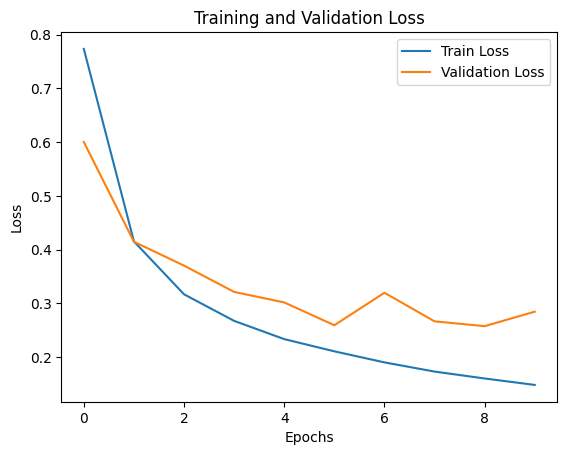

In [ ]:
# Plot Training and Validation Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluation
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [ ]:
# Confusion Matrix and F1 Score
conf_matrix = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
 [[701   0  25  16   5   0 250   0   3   0]
 [  2 979   0  11   5   0   2   0   1   0]
 [  5   1 850   4  57   0  83   0   0   0]
 [  1   2  10 874  49   0  64   0   0   0]
 [  1   1  40  12 867   0  79   0   0   0]
 [  0   0   0   0   0 980   0  14   1   5]
 [ 35   0  40  22  45   0 852   0   6   0]
 [  0   0   0   0   0   4   0 982   0  14]
 [  3   1   1   4   3   1  23   2 962   0]
 [  0   0   0   0   0   2   1  32   0 965]]
F1 Score: 0.9033


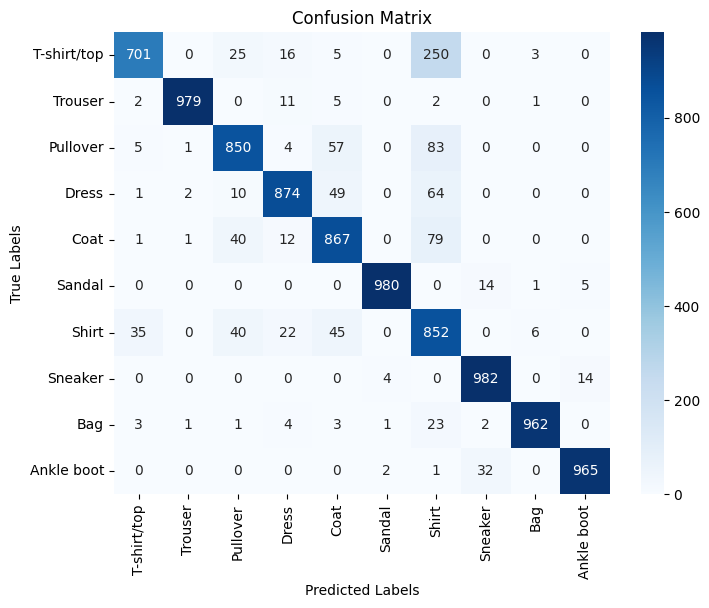

In [ ]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Define Class Names
class_names = train_dataset.classes

# Plot the Confusion Matrix
plot_confusion_matrix(conf_matrix, class_names)
